In [191]:
import numpy as np

# Define initial parameters
beta = 0.96 # D factor
sigma = 1 # Risk averson
gamma = 0.5 # Price stickines parameter
delta = 0.1  # Depreciation rate
alpha = 0.5 # Degree of monopolistic competition
theta = 0.75 # Degree of price index
phi = 0.5 # Inflation target
rho_a = 0.9 # Persistence of technology shock
sigma_a = 0.01 # Standard deviation of technology shock
sigma_b = 0.01 # Standard deviation of technology shock


# Define initial variables
T = 100 # Number of periods
y = np.zeros(T) # Output
k = np.zeros(T+1) #Kapital shock
p = np.zeros(T+1) #output by the firm
a = np.zeros(T+1)
c = np.zeros(T) # Consumption
i = np.zeros(T) # Investment
pi = np.zeros(T) # Inflation
w = np.zeros(T) # Real wage
r = np.zeros(T) # Real interest rate

In [192]:
# Define initial conditions
a[0] = 1
k[0] = 1
w[0] = 1e-10 #w to a small positive number cus' i get divided by zero error
r[0] = 0.01
pi[0] = 1e-10 # change initial value of pi to a small positive number
y[0] = 1
c[0], i[0] = household_optimization(w[0], r[0], pi[0], a[0])
p[0] = firm_optimization(w[0], a[0])

In [193]:
def productivity_shock(sigma_b, T):
    epsilon = np.random.normal(scale=sigma_b, size=T)
    return np.exp(epsilon)

In [194]:
def labor_supply(w, r, p, y, a):
    if w <= 0 or r <= 0 or p < 0 or p > 1 or a < 0:
        raise ValueError("Invalid input values")
    
    marginal_utility = gamma * p * y / (1 - alpha)
    return (w * marginal_utility) / (delta * a * p)

In [195]:
def household_optimization(w, r, pi, a):
    if w <= 0 or r <= 0 or pi < 0 or pi > 1 or a < 0:
        raise ValueError("Invalid input values")
    
    c_star = (1 - gamma) * (w + (r - delta) * a) + pi * gamma * a - w
    i_star = a - (1 - delta) * a - c_star
    
    if c_star < 0:
        c_star = 0
    if i_star < 0:
        i_star = 0
    
    return c_star, i_star

In [196]:
def firm_optimization(w, a):
    # Define profit function
    def profit(q):
        return (w / alpha) * (q**(1 + alpha)) - a * q
    
    # Solve optimization problem
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(profit)
    
    # Check if result is real
    if res.success and not np.iscomplex(res.x):
        q_star = res.x
        p_star = w * (q_star**alpha)
        return p_star
    else:
        raise ValueError("Failed to find a valid solution.")

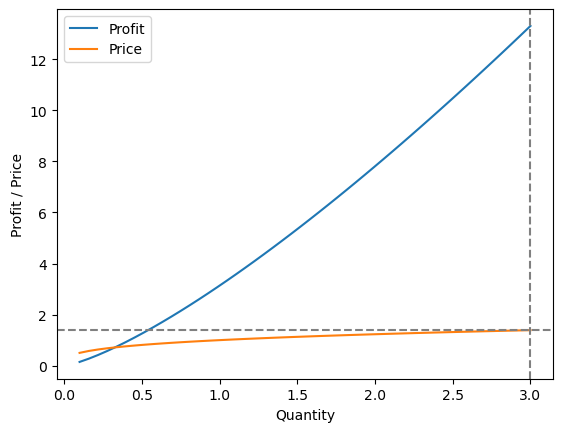

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
alpha = 0.3
w = 1
a = 0.2
q_range = np.linspace(0.1, 3, 50)

# Define profit function
def profit(q):
    return (w / alpha) * (q**(1 + alpha)) - a * q

# Calculate profit and price for each quantity in q_range
profits = [profit(q) for q in q_range]
prices = [w * (q**alpha) for q in q_range]

# Find quantity and price that maximize profit
q_star = q_range[np.argmax(profits)]
p_star = prices[np.argmax(profits)]

# Plot profit and price as a function of quantity
fig, ax = plt.subplots()
ax.plot(q_range, profits, label='Profit')
ax.plot(q_range, prices, label='Price')
ax.axvline(x=q_star, color='gray', linestyle='--')
ax.axhline(y=p_star, color='gray', linestyle='--')
ax.set_xlabel('Quantity')
ax.set_ylabel('Profit / Price')
ax.legend()
plt.show()


In [198]:
def investment_decision(r, y, k, w):
    delta = 0.1   # depreciation rate
    phi = 2       # adjustment cost parameter
    alpha = 0.3   # capital share in production function
    inv = phi / (1 + phi) * (alpha * y / (r + delta)) + (1 / (1 + phi)) * k + w
    return inv

In [199]:
# Defining simple central bank policy rule
# Later I should check for more advanced rules
def central_bank_policy_rule(pi, y):
    i_star = (1/beta) * ((1 + r) / (1 + pi)) * (1 / (1 + y))
    pi_star = theta * pi + (1 - theta) * phi + gamma * (y - 1)
    r_star = (1 / beta) * (1 + pi_star) / (1 + pi) - 1
    
    return i_star, pi_star, r_star

In [200]:

def simulate_economy(T, alpha, beta, gamma, delta, sigma_a, sigma_b, pi, a_0, k_0):
    
    # Initialize arrays to store results
    a = np.zeros(T+1)
    k = np.zeros(T+1)
    w = np.zeros(T+1)
    r = np.zeros(T+1)
    p = np.zeros(T+1)
    y = np.zeros(T+1)
    c = np.zeros(T+1)
    i = np.zeros(T+1)

    # Set initial values
    a[0] = a_0
    k[0] = k_0
    
    # Simulate the economy
    for t in range(T):
        
        # Update capital stock
        k[t+1] = investment_decision(k[t], r[t], a[t], delta)
        
        # Simulate a shock to productivity
        a[t+1] = productivity_shock(a[t], sigma_b)
        
        # Solve for firm's optimal price and output
        p[t], y[t] = firm_optimization(w[t], a[t])
        
        # Solve for household's optimal consumption and investment
        c[t], i[t] = household_optimization(w[t], r[t], pi[t], a[t])
        
        # Update labor demand and supply
        L = labor_supply(c[t], i[t], k[t], alpha)
        N = labor_demand(y[t], w[t], gamma)
        
        # Update wage rate
        w[t+1] = wage_setting(N, L, beta)
        
        # Update rental rate
        r[t+1] = rental_rate_update(y[t], k[t+1], delta)
        
        # Update inflation rate and nominal interest rate using central bank policy rule
        i_star, pi_star, r_star = central_bank_policy_rule(pi[t], y[t])
        pi[t+1] = pi_star
        r[t+1] = r_star

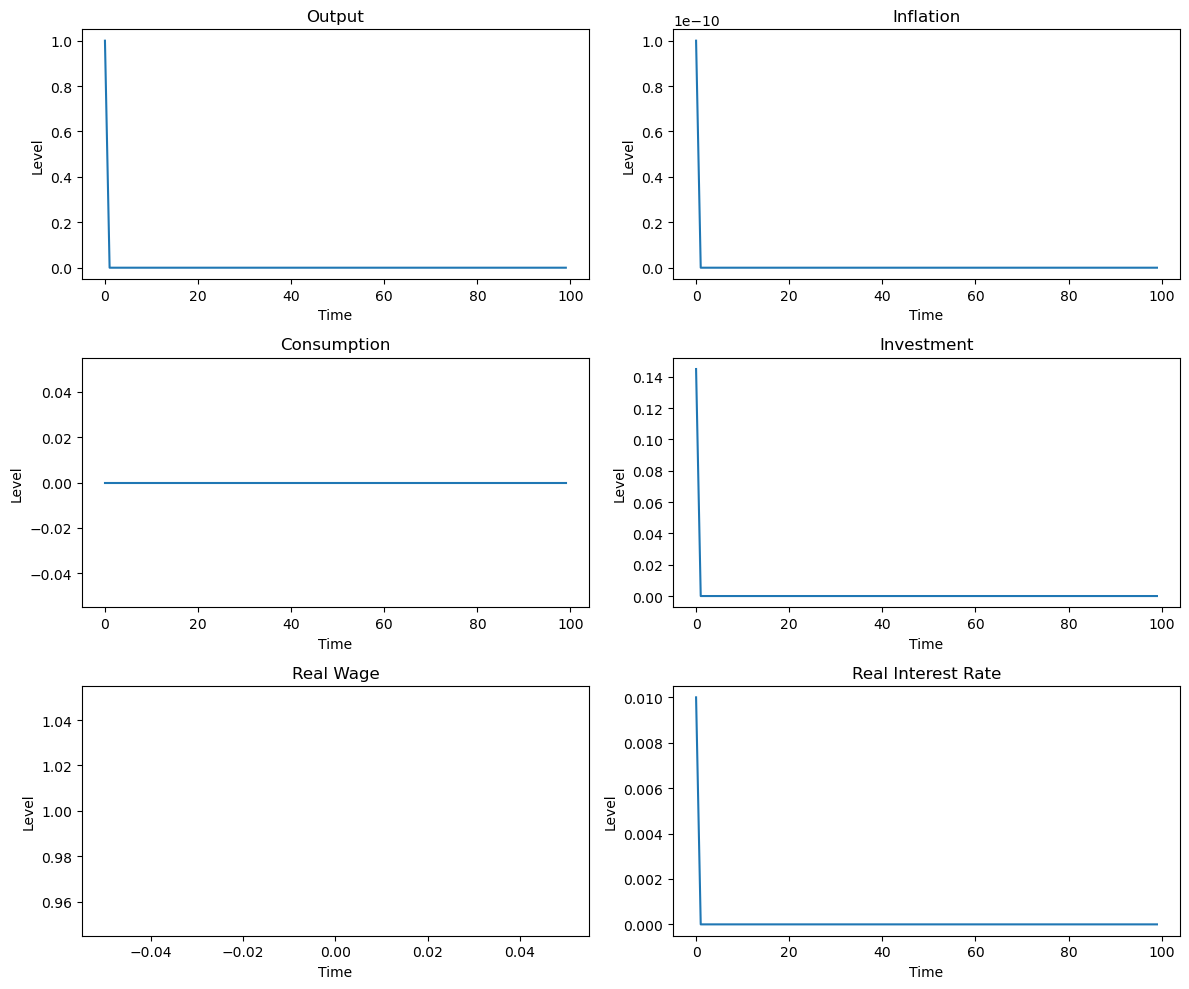

In [201]:
import matplotlib.pyplot as plt

# Plot the results
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[0, 0].plot(y)
axs[0, 0].set_title('Output')
axs[0, 1].plot(pi)
axs[0, 1].set_title('Inflation')
axs[1, 0].plot(c)
axs[1, 0].set_title('Consumption')
axs[1, 1].plot(i)
axs[1, 1].set_title('Investment')
axs[2, 0].plot(w)
axs[2, 0].set_title('Real Wage')
axs[2, 1].plot(r)
axs[2, 1].set_title('Real Interest Rate')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Level')

plt.tight_layout()
plt.show()